In [1]:
# change to parent directory to import module
%cd ..

/home/achilleas/projects/osbuild/metrics


In [2]:
# imports, function definitions, and global settings
import json
import pandas
import report

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import ibmetrics as ib

from datetime import datetime, timedelta

from IPython.display import display, Markdown


def mdprint(msg):
    display(Markdown(msg))
    
matplotlib.rc('font', size=24)

In [3]:
# read data
builds = ib.reader.read("./data/parquet/builds/year_created=2023/month_created=2/day_created=1")
users = pandas.read_json("./data/userinfo.json", dtype=False)
with open("./data/userfilter.txt", encoding="utf-8") as filterfile:
    user_filter = filterfile.read().split("\n")
    
subscriptions = pandas.read_csv("./data/16_image-builder-consumers.tsv",
                                delimiter="\t", parse_dates=[2, 3],
                                dtype={"org_id": str})

filter_ids = ib.data.get_filter_ids(users, user_filter)

mdprint(f"Builds: Read {len(builds)} records")
mdprint(f"Subscriptions: Read {len(subscriptions)} records")

Builds: Read 10583 records

Subscriptions: Read 3700 records

In [4]:
# filtering: remove builds before GA
ga_date = datetime(2022, 5, 4)
ga_idxs = builds["created_at"] >= ga_date
builds = builds.loc[ga_idxs]

# filtering: remove builds of incomplete (current) month
now = datetime.now()
month_start = datetime(year=now.year, month=now.month, day=1)
builds = builds.loc[builds["created_at"] < month_start]
mdprint(f"Builds: Using {len(builds)} records (since GA to start of month)")
subscriptions = subscriptions.loc[subscriptions["created"] < month_start]
mdprint(f"Subscriptions: Using {len(subscriptions)} records (since GA to start of month)")

# filtering: remove internal users
builds = ib.data.filter_orgs(builds, filter_ids)
mdprint(f"Builds: Using {len(builds)} records (after filtering)")
subscriptions = ib.data.filter_orgs(subscriptions, filter_ids)
mdprint(f"Subscriptions: Using {len(subscriptions)} records (after filtering)")

# filtering: only consider cloudapi-v2 builds from subscriptions
subscriptions = subscriptions.loc[subscriptions["element"] == "cloudapi-v2"]
mdprint(f"Subscriptions: Using {len(subscriptions)} records (after filtering for cloudapi-v2)")

Builds: Using 8747 records (since GA to start of month)

Subscriptions: Using 3593 records (since GA to start of month)

Builds: Using 3562 records (after filtering)

Subscriptions: Using 762 records (after filtering)

Subscriptions: Using 699 records (after filtering for cloudapi-v2)

In [5]:
summary = ib.metrics.make_summary(builds)
mdprint(ib.metrics.summarise(summary))

Summary
=======

Period: 2022-05-04 14:11:47.137615 - 2023-01-31 23:32:36.587898

- Total builds: 3562
- Number of users: 1302
- Builds with packages: 1978
- Builds with filesystem customizations: 1138
- Builds with custom repos: 69

In [6]:
# Calculate total subscribed machine duration
durations = []

n_active = 0
# machine is active if it checked in after the cutoff: last day of the month we're looking at
cutoff = month_start - timedelta(days=1)
for _, sub in subscriptions.iterrows():
    start = np.datetime64(sub["created"])
    
    if sub["lastcheckin"] == "None":
        # skip machines that never checked in after creation
        continue
    end = np.datetime64(sub["lastcheckin"])

    d = (end-start).astype(int)/1000000 # microseconds to seconds
    
    if end > cutoff:
        n_active += 1
    durations.append(d)

total_duration = sum(durations)
print(f"{total_duration} seconds total active instances")
print(f"{np.mean(durations)} seconds average lifetime per instance")
print(f"{n_active} active instances (checked in within one day before {month_start})")
print(f"{len(durations)} instances that checked in at least once")

1362922364.0 seconds total active instances
2010209.97640118 seconds average lifetime per instance
220 active instances (checked in within one day before 2023-02-01 00:00:00)
678 instances that checked in at least once


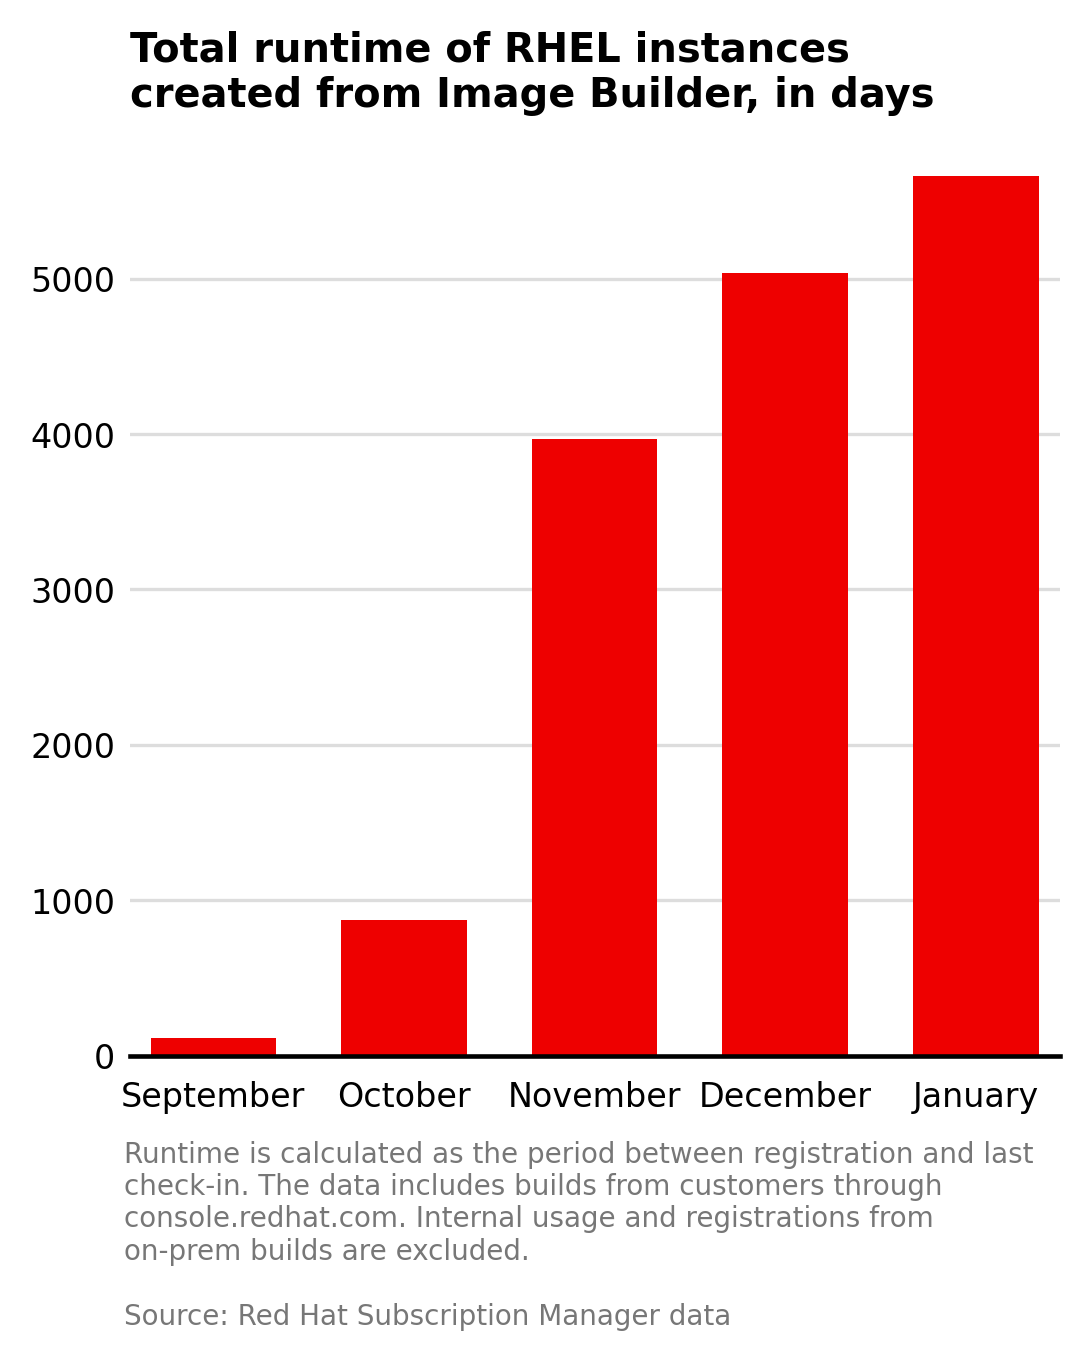

In [7]:
ib.plot.monthly_active_time(subscriptions)

Text(0.13, -0.05, 'An organization is an account for a single customer, not an individual user.\nOrganizations are counted as Recurring if they have built an image\nin any preceding month. Internal Red Hat organizations are excluded.\n\nSource: Image Builder Production Database')

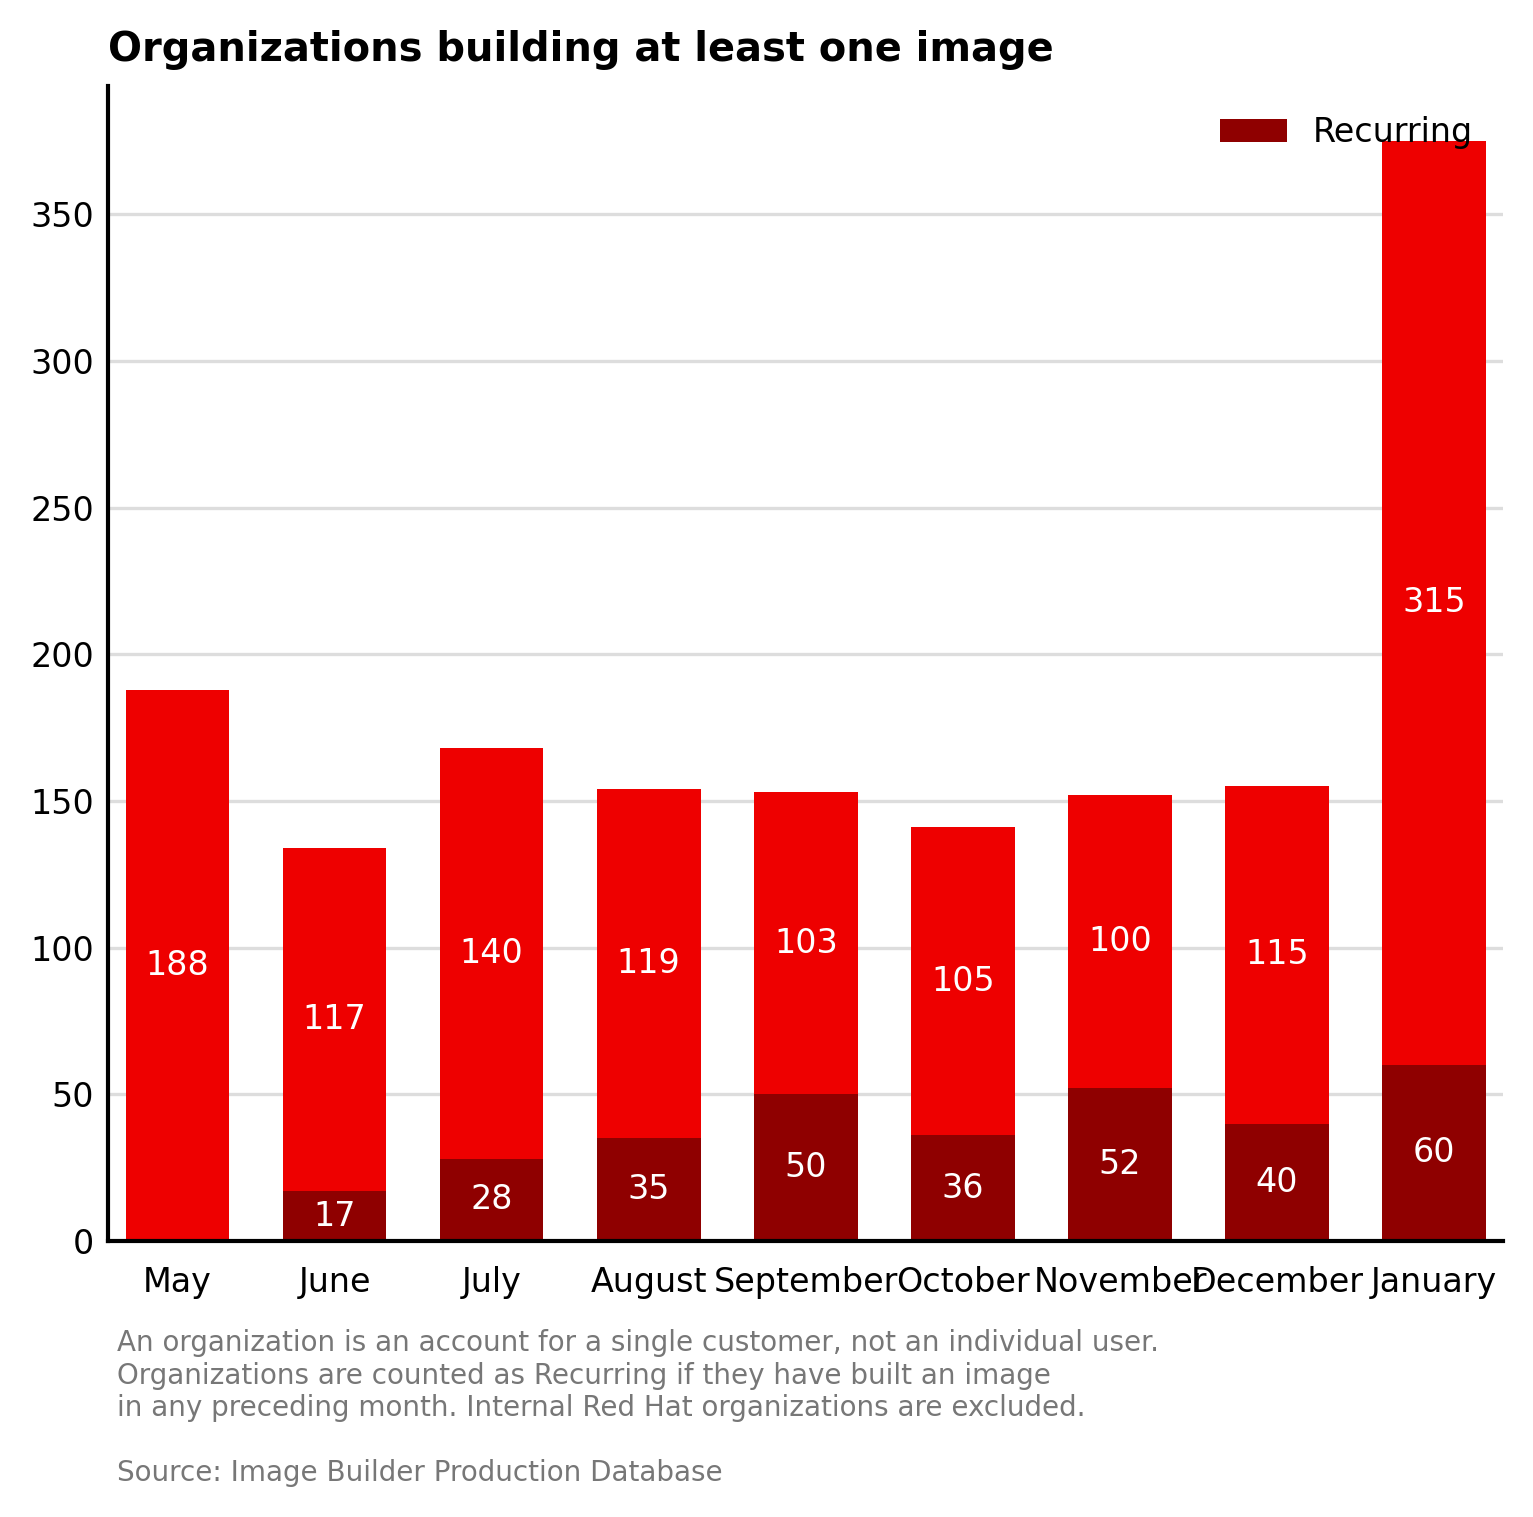

In [8]:
# why doesn't it take from matplotlibrc?
matplotlib.rcParams["figure.dpi"] = 300
matplotlib.rcParams["font.size"] = 8

plt.style.use("./notebooks/redhat.mplstyle")

fig, ax = plt.subplots(figsize=(6, 5))
# fig.suptitle("Organizations building at least one image", x=0)

ax.grid(axis="y", color="#dddddd")
# ax.spines["bottom"].set(linewidth=1.1)
ax.xaxis.set_tick_params(size=0, pad=6)
ax.yaxis.set_tick_params(size=0)
# ax.yaxis.tick_right()

# ticks = ax.get_yticklabels()
# for tick in ticks:
#    tick.set_verticalalignment("bottom")
#   tick.set_horizontalalignment("right")

ax.set_axisbelow(True)
ax.set_title("Organizations building at least one image", loc="left", fontweight="bold")

user_counts, months = ib.metrics.monthly_users(builds)
new_user_counts, months = ib.metrics.monthly_new_users(builds)
old_user_counts = user_counts - new_user_counts

bar_width = 0.66

def format_label(n):
    return str(n) if n >= 10 else ''

names = [m.month_name() for m in months]
# bar = ax.bar(names, counts, width=0.66)
bar_new = ax.bar(names, new_user_counts, width=bar_width, bottom=old_user_counts)
bar_old = ax.bar(names, old_user_counts, width=bar_width, label="Recurring")

# this won't work for bars that are too small. use annotate()
ax.bar_label(bar_new, map(format_label, new_user_counts), label_type="center", color="#ffffff")
ax.bar_label(bar_old, map(format_label, old_user_counts), label_type="center", color="#ffffff")
ax.legend()

ax.set_xlim(-bar_width * 2/3, len(names) - 1 + bar_width * 2/3)

caption = ("An organization is an account for a single customer, not an individual user.\n"
           "Organizations are counted as Recurring if they have built an image\n"
           "in any preceding month. Internal Red Hat organizations are excluded.\n\n"
           "Source: Image Builder Production Database")
fig.text(0.13, -0.05, caption, fontsize="small", color="#777777")

Text(0.13, -0.11, 'Bare metal refers to the installer (ISO).\nEdge refers to all edge image types: commit, container, installer (ISO).\nBuilds from internal Red Hat organizations are excluded.\n\nSource: Image Builder Production Database')

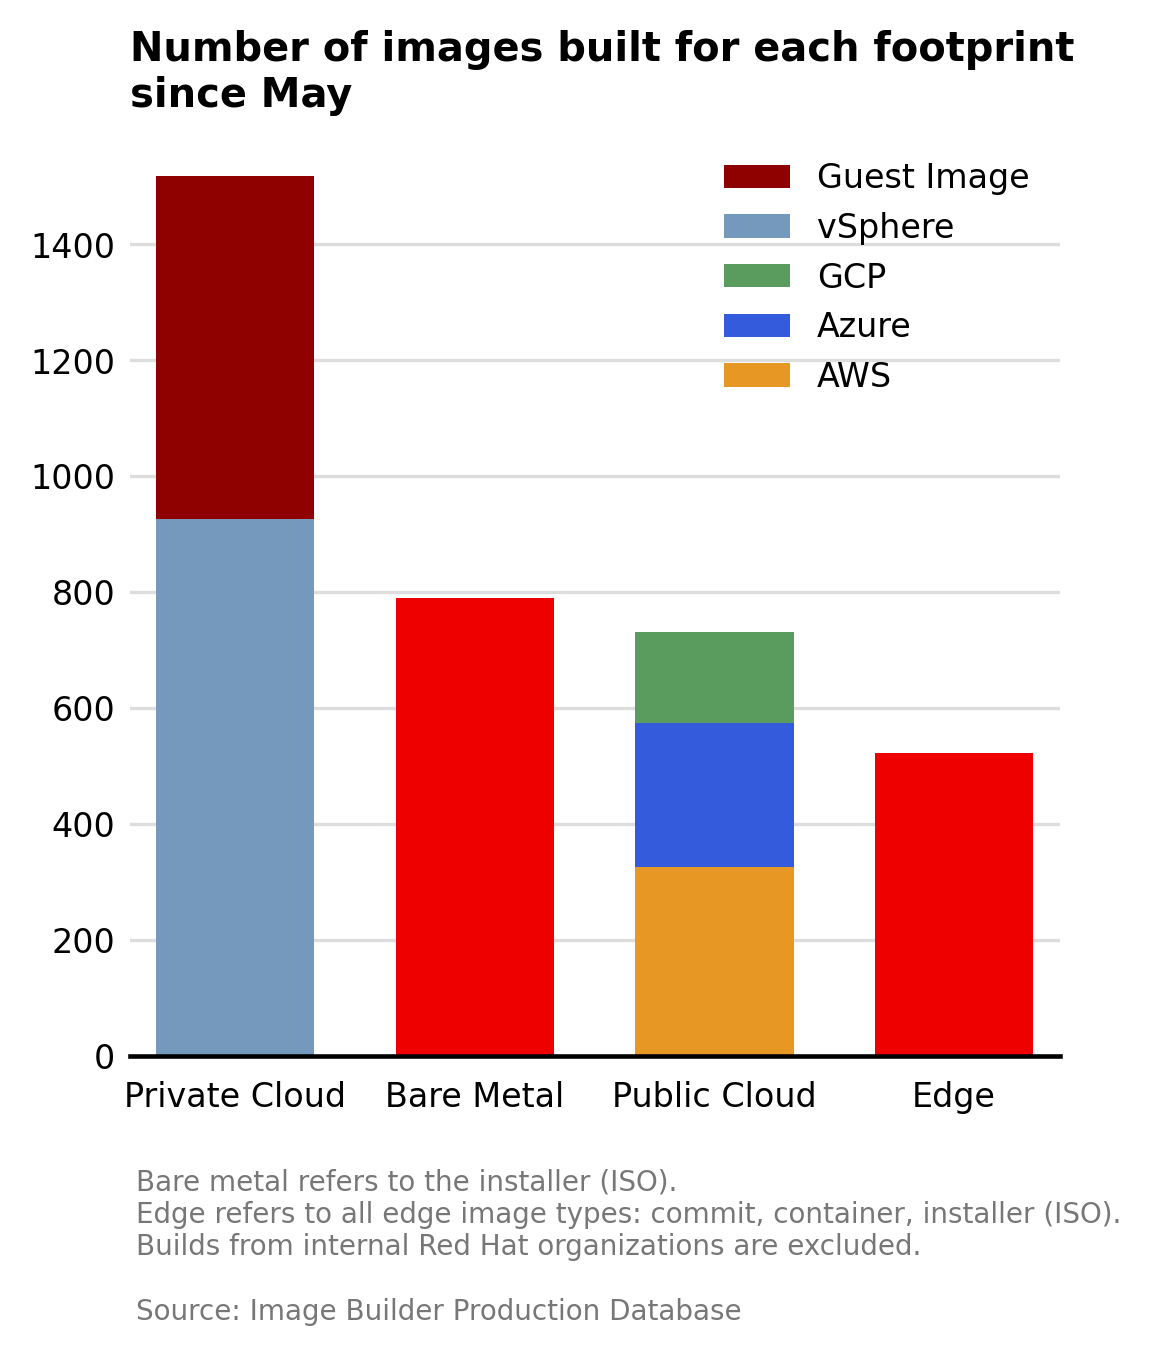

In [9]:
matplotlib.rcParams["figure.dpi"] = 300
matplotlib.rcParams["font.size"] = 8

# distribution of single-footprint users (stacked cloud)
# it's a little hacky, but that's okay for this notebook
fig, ax = plt.subplots(figsize=(4, 4))

ax.grid(axis="y", color="#dddddd")
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set(linewidth=1.1)
ax.xaxis.set_tick_params(size=0, pad=6)
ax.yaxis.set_tick_params(size=0)
ax.set_axisbelow(True)
ax.set_title("Number of images built for each footprint\nsince May", loc="left", fontweight="bold")

bar_width = 0.66

sfp_users = ib.metrics.single_footprint_users(builds)
fp_counts = sfp_users["footprint"].value_counts()
# ax.bar(fp_counts.index, fp_counts.values)

footprints = ib.metrics.footprints(builds)
fp_counts = footprints["footprint"].value_counts()

bottom = 0
priv_clouds = ["guest-image", "vsphere"]
priv_sum = sum(v if k in priv_clouds else 0 for k, v in fp_counts.items())

grouped = fp_counts.copy()
grouped["private-cloud"] = priv_sum
for priv in priv_clouds:
    del grouped[priv]

bottom = 0
clouds = ["gcp", "azure", "aws"]
cloud_sum = sum(v if k in clouds else 0 for k, v in fp_counts.items())

grouped["cloud"] = cloud_sum
for cloud in clouds:
    del grouped[cloud]

names = {
    "private-cloud": "Private Cloud",
    "cloud": "Public Cloud",
    "bare-metal": "Bare Metal",
    "edge": "Edge"
} 

grouped.sort_values(ascending=False, inplace=True)
ax.bar([names[i] for i in grouped.index], grouped.values, width=bar_width)  # plot with grouped cloud to get them in order (sorted)
# for ft in cloud_grouped_feet.items():
#    if ft[0] == "cloud":
#        continue

labels = {
    "aws": "AWS",
    "azure": "Azure",
    "gcp": "GCP",
    "guest-image": "Guest Image",
    "vsphere": "vSphere",
}

colors = {
    "aws": "#E79824",
    "azure": "#345BDB",
    "gcp": "#599C5D",
    "guest-image": "#8f0000",
    "vsphere": "#7598bd",
}

# draw over cloud bars with breakdown values of individual image types
# Note: the legend order is top-to-bottom in order of creation, so let's draw the clouds in the same order
bottom = sum(fp_counts[p] for p in priv_clouds)  # top of the bar
for priv in priv_clouds:
    bottom -= fp_counts[priv]
    bar = ax.bar(names["private-cloud"], fp_counts[priv], bottom=bottom, label=labels.get(priv, priv), width=bar_width, color=colors[priv])
    # ax.bar_label(bar, fp_counts, label_type="center", color="#ffffff")

bottom = sum(fp_counts[cld] for cld in clouds)  # top of the bar
for cld in clouds:
    bottom -= fp_counts[cld]
    bar = ax.bar(names["cloud"], fp_counts[cld], bottom=bottom, label=labels.get(cld, cld), width=bar_width, color=colors[cld])
    # ax.bar_label(bar, fp_counts, label_type="center", color="#ffffff")


ax.set_xlim(-bar_width * 2/3, len(clouds) + bar_width * 2/3)

ax.legend()
caption = ("Bare metal refers to the installer (ISO).\n"
           "Edge refers to all edge image types: commit, container, installer (ISO).\n"
           "Builds from internal Red Hat organizations are excluded.\n\n"
           "Source: Image Builder Production Database")
fig.text(0.13, -0.11, caption, fontsize="small", color="#777777")